In [1]:
import sys
sys.path.insert(0, '/home/jovyan/ros/')

%load_ext autoreload
%autoreload 2

In [2]:
import itertools as it

import altair as A
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import pandas as pd
import scipy.stats as st
from numba import njit
import toolz.curried as z

from ros.utils.common import hstack, vstack, plot_wrap
from ros.utils import plot as plu
from ros.utils import bootstrap as bs

import dscontrib.wbeard as wb

str_concat = z.compose('-'.join, z.map(str))
lmap = z.comp(list, map)

Warning, $BQ_CREDS not found in environment


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


# Build dataset

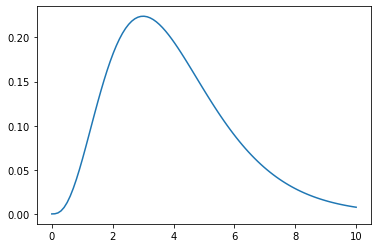

In [3]:
xs = np.linspace(0, 10, 100)
ys = st.gamma(4).pdf(xs)

plt.plot(xs, ys)

In [4]:
@njit
def gen_pre_post(win7, win7_fact, treat, treat_fact, treat_std=.15, exp=True):
    pre = nr.gamma(4 + win7_fact * win7)
    post = pre + nr.randn() * treat_std + (treat_fact * treat)
    if exp:
        return np.exp(pre), np.exp(post)
    return pre, post

### With Numba

In [51]:
WIN7_FACT = 1.2
TREAT_MU = 0.15
TREAT_SD = .15
n_each = 1_000
n_win_7 = {0: n_each, 1: n_each}

@njit
def randn(mu, sig, size=1):
    return nr.randn(size) * sig + mu

@njit
def gen_log_first_paint_pre_post(win7, treat, size=1):
    pre = nr.gamma(4 + WIN7_FACT * win7, 1, size=size)
    return np.concatenate((pre, pre + randn(TREAT_MU * treat, TREAT_SD, size=size)))

\begin{align}
fp_{baseline} & \sim \mathrm{Gamma}(4 + \mathbb 1_{win7} \cdot \mu_{win}) \\
w_{treat} & \sim \mathcal N (\mathbb 1_{treat} \cdot \mu_{treat}, \sigma_{treat}) \\
\log(first\_paint) & = fp_{baseline} + w_{treat}
\end{align}

In [61]:
WIN7_FACT = 1.2
TREAT_FACT = 0.15
n_each = 1_000
n_win_7 = {0: n_each, 1: n_each}


def add_columns(df):
    pre_post = pd.DataFrame(
        [
            gen_log_first_paint_pre_post(win7, treat=treat)
            #gen_pre_post(win7, win7_fact=WIN7_FACT, treat=treat, treat_fact=TREAT_FACT,)
            for win7, treat in df[["win7", "treat"]].itertuples(index=False)
        ],
        columns=["lpre", "lpost"],
    ).assign(
        pre=lambda df: np.exp(df.lpre),
        post=lambda df: np.exp(df.lpost),
    )
    df = hstack([df, pre_post])
    df = (
        df.assign(os=lambda df: df.win7.map({0: "win10", 1: "win7"}))
        .reset_index(drop=0)
        .rename(columns={"index": "id"})
    )
    df["demo"] = [
        str_concat(tup)
        for tup in df[["treat", "os"]]
        .assign(treat=lambda df: df.treat.map({1: "treat", 0: "control"}))
        .itertuples(index=False)
    ]
    return df


def create_test_pop(n_each=50):
    data_dct = [
        {"win7": win7, "treat": treat}
        for win7 in (0, 1)
        for treat in (0, 1)
        for _ in range(n_win_7[win7])
    ]
    df_ = pd.DataFrame(data_dct)
    df = df_.pipe(add_columns)
    return df

def stack_pre_post(df):
    """
    demo[graphic] is concatenated values for
    ["treat", "os"]
    demo2 is for ["treat", "os", "pre"]
    """
    dfs = (
        df.set_index(["id", "win7", "os", "treat", "demo"])
        .stack()
        .reset_index(drop=0)
        .rename(columns={"level_5": "pre", 0: "y"})
        .assign(demo2=lambda df: lmap(str_concat, df[['demo', 'pre']].itertuples(index=False)))
        .assign(pre=lambda df: (df.pre == "pre").astype(int))
    )
    return dfs

df = create_test_pop()
dfs = stack_pre_post(df.drop(["lpre", 'lpost'], axis=1))
print(len(df))
df.drop_duplicates("win7")

4000


,id,win7,treat,lpre,lpost,pre,post,os,demo
0,0,0,0,3.190839,3.246262,24.308814,25.694120,win10,control-win10
2000,2000,1,0,7.424998,7.459481,1677.396456,1736.246055,win7,control-win7


In [62]:
dfs[:3]

,id,win7,os,treat,demo,pre,y,demo2
0,0,0,win10,0,control-win10,1,24.308814,control-win10-pre
1,0,0,win10,0,control-win10,0,25.694120,control-win10-post
2,1,0,win10,0,control-win10,1,728.374138,control-win10-pre


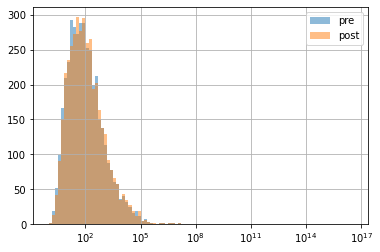

In [63]:
lbins = np.logspace(0, np.log(df.post.max()), 100)
df.pre.hist(bins=lbins, density=0, alpha=0.5)
df.post.hist(
    bins=lbins, density=0, alpha=0.5,
)
plt.legend(["pre", "post"])
plt.xscale("log")

- control: no difference pre/post

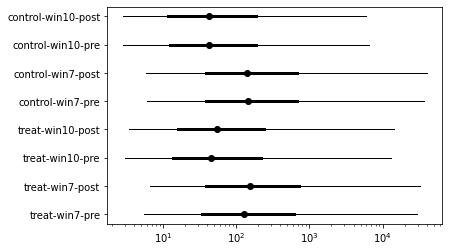

In [64]:
plu.plot_groupby(dfs, 'demo2', 'y', quants=[50, 95])
plt.xscale('log')

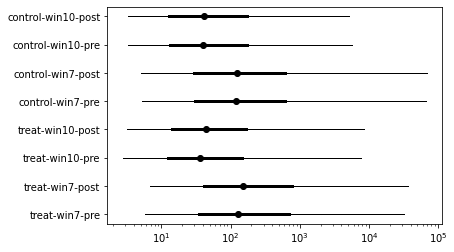

In [18]:
# df.groupby(['win7', 'treat', 'os'])[['pre', 'post']].median()

# Difference in means

In [19]:
dfs[:3]

,id,win7,os,treat,demo,pre,y,demo2
0,0,0,win10,0,control-win10,1,32.703464,control-win10-pre
1,0,0,win10,0,control-win10,0,37.551647,control-win10-post
2,1,0,win10,0,control-win10,1,72.855866,control-win10-pre


In [20]:
dfs.query("pre == 1").groupby('treat').y.mean()

treat
0     9135.211072
1    27603.309209
Name: y, dtype: float64

In [21]:
# bsmeans = bs.mk_bootstrap_gb(dfs, gb='treat')
# del bsmeans

In [22]:
def bootstrap_stat_diff(df, gbcol, ycol, stat_fn=np.mean, n_reps=1_000):
    """
    `gbcol` needs to be col of 0 and 1's, designating
    the groups being compared.
    """
    control = df[ycol][df[gbcol] == 0].values
    treat = df[ycol][df[gbcol] == 1].values
    size = len(control)
    stats = []
    
    for _ in range(n_reps):
        ac = nr.choice(control, size=size, replace=True)
        at = nr.choice(treat, size=size, replace=True)
        stats.append(stat_fn(at) - stat_fn(ac))
    
    return np.array(stats)

diffs = bootstrap_stat_diff(dfs.query("pre == 0"), 'treat', 'y', stat_fn=np.mean, n_reps=10_000)

In [23]:
diffs_log = bootstrap_stat_diff(
    dfs.query("pre == 0").assign(yl=lambda df: df.y.pipe(np.log)),
    "treat",
    "yl",
    stat_fn=np.mean,
    n_reps=10_000,
)

diffs_ = plot_wrap(diffs)
diffsl_ = plot_wrap(diffs_log)

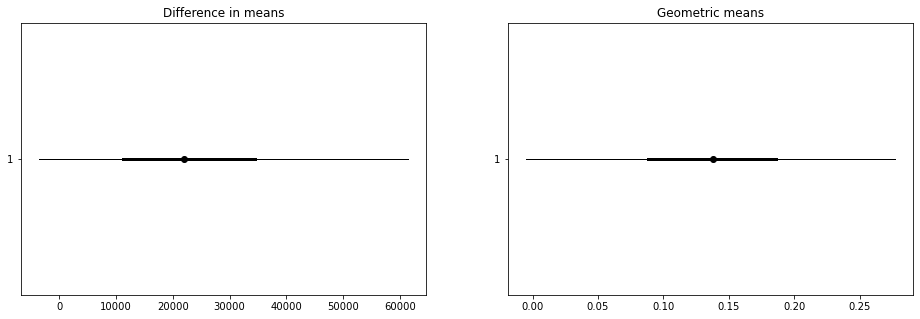

In [24]:
axs, spi = wb.plot_utils.mk_sublots(nrows=1, ncols=2, figsize=(16, 5))

spi.n
plt.title('Difference in means')
plu.plot_groupby(diffs_, 'g', 'y', )
# plt.xscale('log')

spi.n
plt.title('Geometric means')
plu.plot_groupby(diffsl_, 'g', 'y', )
# plt.xscale('log')

## As linear regression

In [25]:
from bambi import Model
import arviz as az

data = dfs.assign(yl=lambda df: df.y.pipe(np.log))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [26]:
data[:3]

,id,win7,os,treat,demo,pre,y,demo2,yl
0,0,0,win10,0,control-win10,1,32.703464,control-win10-pre,3.487481
1,0,0,win10,0,control-win10,0,37.551647,control-win10-post,3.625717
2,1,0,win10,0,control-win10,1,72.855866,control-win10-pre,4.288483


In [27]:
mod = Model(data.query("pre == 0").copy())

In [28]:
fit = mod.fit("yl ~ treat", samples=1000, chains=4, target_accept=.8)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [yl_sd, treat, Intercept]
INFO:pymc3:NUTS: [yl_sd, treat, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: Fut

In [29]:
posterior_treatment = plot_wrap(fit.posterior.treat.values.ravel())

In [30]:
post_plus_boot = vstack([
    diffsl_.assign(g='bootstrapped_mean'),
    posterior_treatment.assign(g='linear model posterior')
])

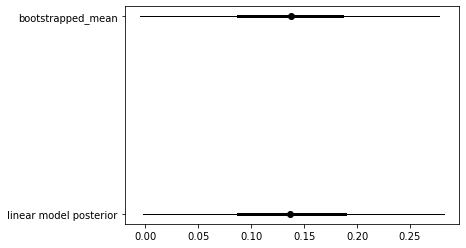

In [31]:
plu.plot_groupby(post_plus_boot, 'g', 'y')

# Blocking

In [32]:
df.groupby(['os', 'treat']).post.median().unstack()

treat,0,1
os,,
win10,40.613725,44.053866
win7,122.656509,150.463720


In [33]:
df_pre_post = df.assign(pre_l=lambda df: df.pre.pipe(np.log), post_l=lambda df: df.post.pipe(np.log))
mod_block = Model(df_pre_post.copy())

In [34]:
fit_block = mod_block.fit("post_l ~ pre_l + treat + win7", samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [post_l_sd, win7, treat, pre_l, Intercept]
INFO:pymc3:NUTS: [post_l_sd, win7, treat, pre_l, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [35]:
posterior_treatment_block = plot_wrap(fit_block.posterior.treat.values.ravel())

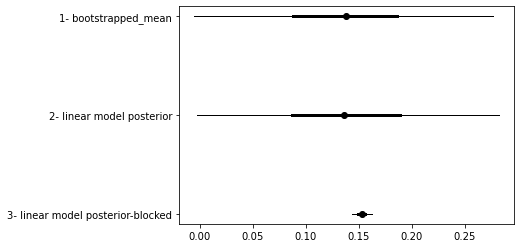

In [38]:
post_boot_block = vstack([
    posterior_treatment.assign(g='2- linear model posterior'),
    posterior_treatment_block.assign(g='3- linear model posterior-blocked'),
    diffsl_.assign(g='1- bootstrapped_mean'),
])

plu.plot_groupby(post_boot_block, 'g', 'y', quants=[50, 95])

INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f93ec6e8810>],
      dtype=object)

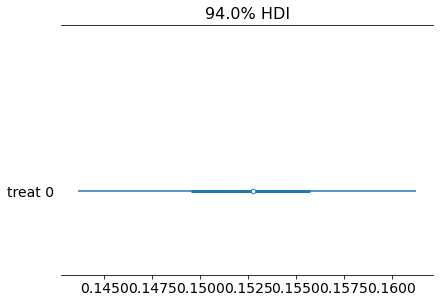

In [37]:
# 'pre_l',  'win7'
az.plot_forest(fit_block, var_names=['treat', ], combined=True)

In [209]:
TREAT_FACT

0.6

In [196]:
az.summary(fit_block)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],-0.013,0.021,-0.053,0.024,0.0,0.0,2388.0,2047.0,2391.0,2238.0,1.0
pre_l[0],1.008,0.009,0.992,1.025,0.0,0.0,2584.0,2584.0,2590.0,2301.0,1.0
treat[0],0.259,0.015,0.230,0.286,0.0,0.0,3062.0,3062.0,3071.0,2187.0,1.0
win7[0],0.009,0.016,-0.018,0.040,0.0,0.0,3585.0,2304.0,3573.0,2752.0,1.0
post_l_sd,0.106,0.006,0.096,0.116,0.0,0.0,2839.0,2839.0,2810.0,1712.0,1.0


In [193]:
df_pre_post[:3]

,id,win7,treat,pre,post,os,demo,pre_l,post_l
0,0,0,0,94.687720,96.608654,win10,control-win10,1.976294,1.985016
1,1,0,0,6.234990,5.454784,win10,control-win10,0.794836,0.736778
2,2,0,0,4.155166,4.699156,win10,control-win10,0.618588,0.672020


In [191]:
df_pre_post[:3]

,id,win7,treat,pre,post,os,demo,pre_l,post_l
0,0,0,0,94.687720,96.608654,win10,control-win10,1.976294,1.985016
1,1,0,0,6.234990,5.454784,win10,control-win10,0.794836,0.736778
2,2,0,0,4.155166,4.699156,win10,control-win10,0.618588,0.672020


In [185]:
data[:3]

,id,win7,os,treat,demo,pre,y,demo2,yl
0,0,0,win10,0,control-win10,1,94.687720,control-win10-pre,1.976294
1,0,0,win10,0,control-win10,0,96.608654,control-win10-post,1.985016
2,1,0,win10,0,control-win10,1,6.234990,control-win10-pre,0.794836


# Plots

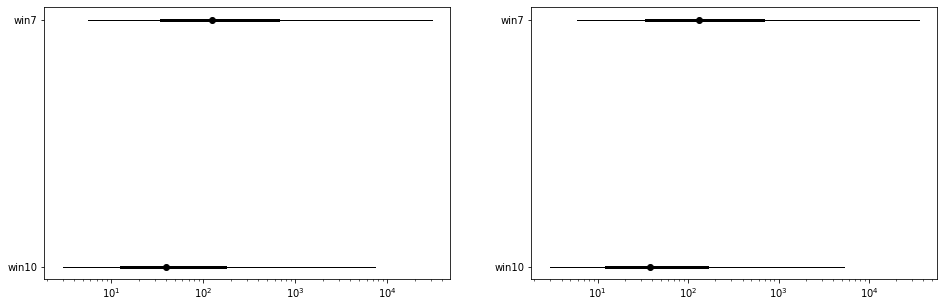

In [85]:
import dscontrib.wbeard as wb
axs, spi = wb.plot_utils.mk_sublots(nrows=1, ncols=2, figsize=(16, 5))

spi.n
df = create_test_pop(5000)
plu.plot_groupby(df, 'os', 'pre')
plt.xscale('log')

spi.n
df = create_test_pop(5000)
plu.plot_groupby(df, 'os', 'pre')
plt.xscale('log')

In [7]:
def mk_bootstrap_df(bs_dct, n_reps=1_000):
    dfs = [
        pd.DataFrame({'y': bs.draw_replicates(n_reps)}).assign(g=k)
        for k, bs in bs_dct.items()
    ]
    df = pd.concat(dfs)
    return df

means_ = {
    k: wb.bootstrap.BootstrapStat(gdf.pre, stat=np.mean)
    for k, gdf in df.groupby('os')
}
mean_draws = mk_bootstrap_df(means_, n_reps=10_000)

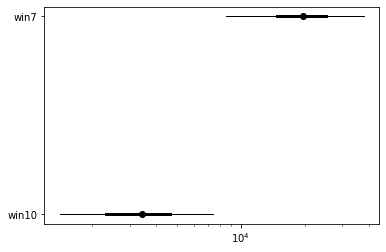

In [9]:
plu.plot_groupby(mean_draws, 'g', 'y', quants=[50, 95])
plt.xscale('log')

In [10]:
df[:3]

,win7,pre,post,os
0,0,28.457386,35.924005,win10
1,0,92.697897,158.996297,win10
2,0,31.821052,57.778453,win10


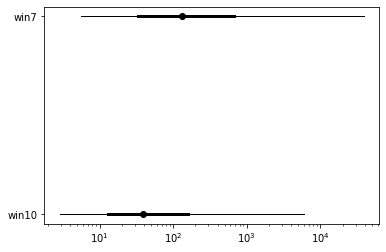

In [25]:

df = create_test_pop(5000)

plot_groupby(df.assign(os=lambda df: df.win7.map({0: 'win10', 1: 'win7'})), 'os', 'pre')

plt.xscale('log')

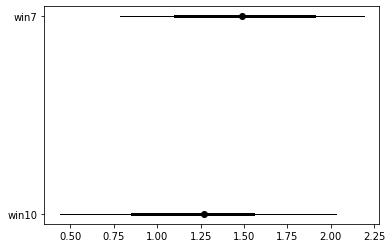

In [37]:

        
plot_probs(sp)

In [56]:
df.groupby(['win7'])[['pre', 'treat']].quantile([.025, .25, .75, .975]).unstack()
# .T.unstack()

pre                                   treat                      \
         0.025     0.250     0.750     0.975     0.025     0.250     0.750   
win7                                                                         
0     1.291482  2.291133  4.832630  6.746378  2.187699  3.440991  6.001139   
1     1.893204  3.907341  6.753467  9.801736  2.651389  4.877444  8.005081   

                 
          0.975  
win7             
0      7.809183  
1     10.797514

In [37]:
df.groupby('win7').pre.mean()

win7
0    3.943179
1    5.037273
Name: pre, dtype: float64

In [25]:

for win7, gdf in df.groupby('win7'):
    1
    
del win7

In [26]:
win7_factor = 1.2

0      2.478191
1      5.925980
2      3.496899
3      2.763261
4      4.099979
         ...   
195    6.584048
196    4.732905
197    8.471105
198    5.075637
199    6.515102
Name: win7, Length: 200, dtype: float64

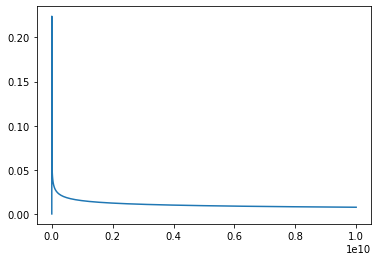

In [10]:
plt.plot(10 ** xs, ys)

# Junk

In [ ]:
def gen_times(win7):
    times = st.gamma(4 + win7_factor * win7).rvs(len(gdf))
    return times

def gen_times_shape(gshape):
    times = st.gamma(gshape).rvs(len(gdf))
    return times

In [ ]:


def gamma_shape(win7):
    return 4 + win7_factor * win7
    
def add_columns(df):
    df['gshape'] = gamma_shape(df.win7)
#     df['pre'] = df.groupby('win7').win7.transform(gen_times)
    df['pre'] = df.groupby('win7').gshape.transform(gen_times_shape)
    df['treat'] = df['pre'] + nr.randn(len(df)) * .25 + 1
    return df

df = pd.DataFrame(data_dct)
df = df.pipe(add_columns)
df.drop_duplicates()